Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   UnderwrittenCoverID       1000098 non-null  int64  
 1   PolicyID                  1000098 non-null  int64  
 2   TransactionMonth          1000098 non-null  object 
 3   IsVATRegistered           1000098 non-null  bool   
 4   Citizenship               1000098 non-null  object 
 5   LegalType                 1000098 non-null  object 
 6   Title                     1000098 non-null  object 
 7   Language                  1000098 non-null  object 
 8   Bank                      854137 non-null   object 
 9   AccountType               959866 non-null   object 
 10  MaritalStatus             991839 non-null   object 
 11  Gender                    990562 non-null   object 
 12  Country                   1000098 non-null  object 
 13  Province     

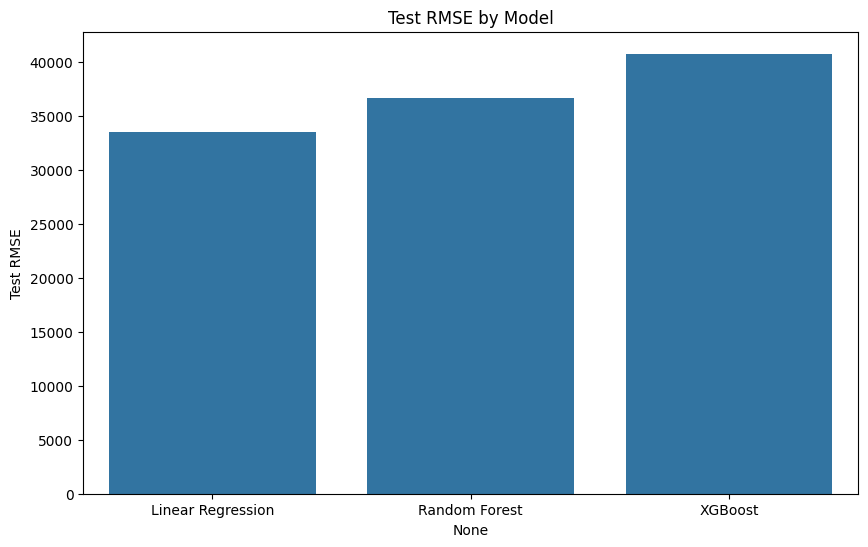

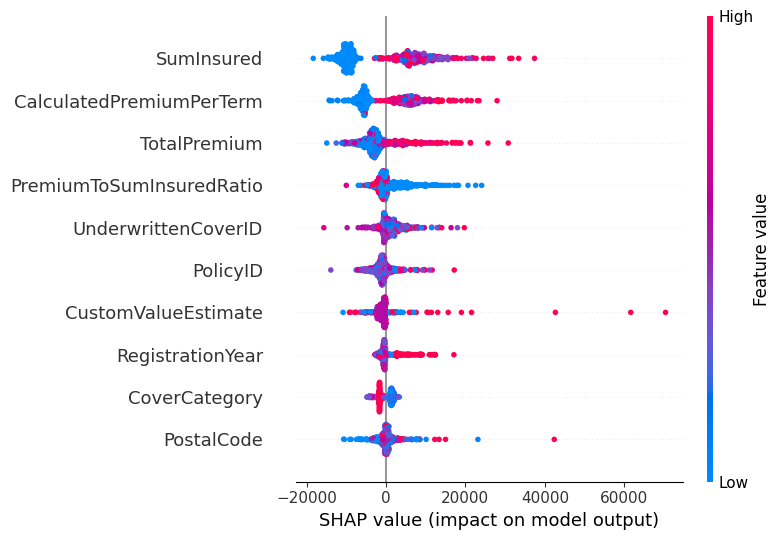


Classification Metrics:
Accuracy     0.997100
Precision    1.000000
Recall       0.001721
F1-Score     0.003436
dtype: float64


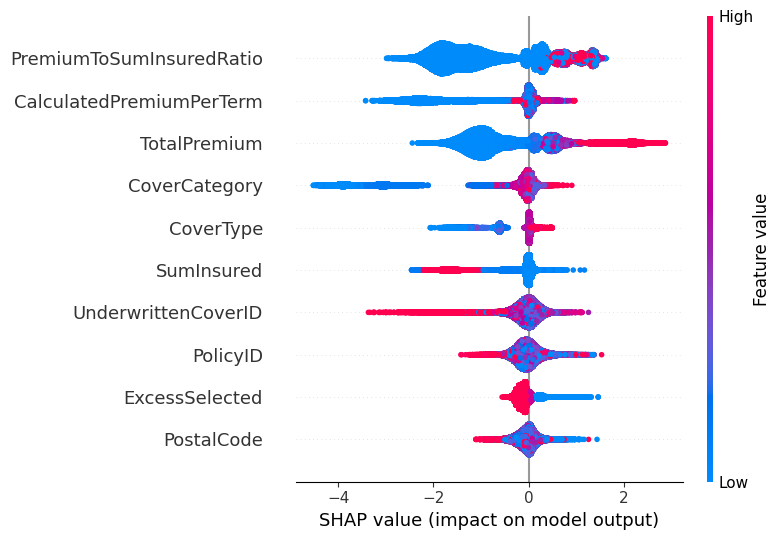

In [183]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('../data/MachineLearningRating_v3.txt', sep='|')
print("Dataset Info:")
print(data.info())
print("\nFirst 5 Rows:")
print(data.head())
print("\nColumn Data Types:")
print(data.dtypes)

print("\nMissing Values Before Imputation:")
print(data.isnull().sum())

numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
print("\nInitial Numerical Columns:", numerical_cols)
print("Number of Initial Numerical Columns:", len(numerical_cols))

print("\nInspecting Numerical Columns:")
for col in numerical_cols:
    print(f"\nColumn: {col}")
    print(f"Data Type: {data[col].dtype}")
    print(f"Sample Values: {data[col].head().tolist()}")
    print(f"NaN Count: {data[col].isna().sum()}")
    try:
        data[col].astype(float)
        print(f"{col} is convertible to float.")
    except (ValueError, TypeError) as e:
        print(f"Warning: {col} contains non-numeric data: {e}")

valid_numerical_cols = []
for col in numerical_cols:
    try:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        if data[col].notnull().any():
            valid_numerical_cols.append(col)
        else:
            print(f"Warning: {col} is entirely NaN after conversion, excluding from imputation.")
    except Exception as e:
        print(f"Warning: Failed to convert {col} to numeric: {e}")

numerical_cols = valid_numerical_cols
print("\nValid Numerical Columns for Imputation:", numerical_cols)
print("Number of Valid Numerical Columns:", len(numerical_cols))

if numerical_cols:
    imputer_num = SimpleImputer(strategy='median')
    imputed_num = imputer_num.fit_transform(data[numerical_cols])
    print(f"\nShape of imputed_num: {imputed_num.shape}")
    print(f"Expected Columns: {len(numerical_cols)}")
    if imputed_num.shape[1] != len(numerical_cols):
        print("Error: Mismatch in number of columns after imputation.")
        raise ValueError(f"Imputed shape {imputed_num.shape} does not match expected columns {len(numerical_cols)}")
    imputed_num_df = pd.DataFrame(imputed_num, columns=numerical_cols, index=data.index)
    data[numerical_cols] = imputed_num_df

categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical Columns:", categorical_cols)
if categorical_cols:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    imputed_cat = imputer_cat.fit_transform(data[categorical_cols])
    print(f"Shape of imputed_cat: {imputed_cat.shape}")
    imputed_cat_df = pd.DataFrame(imputed_cat, columns=categorical_cols, index=data.index)
    data[categorical_cols] = imputed_cat_df

print("\nMissing Values After Initial Imputation:")
print(data.isnull().sum())

if 'RegistrationYear' in data.columns:
    try:
        data['RegistrationYear'] = pd.to_numeric(data['RegistrationYear'], errors='coerce')
        data['VehicleAge'] = 2015 - data['RegistrationYear']
        data['VehicleAge'] = data['VehicleAge'].fillna(data['VehicleAge'].median())
    except Exception as e:
        print(f"Warning: Could not compute VehicleAge: {e}")
        data['VehicleAge'] = 0
else:
    print("Warning: RegistrationYear not found, setting VehicleAge to 0.")
    data['VehicleAge'] = 0

if 'CalculatedPremiumPerTerm' in data.columns and 'SumInsured' in data.columns:
    data['PremiumToSumInsuredRatio'] = data['CalculatedPremiumPerTerm'] / data['SumInsured'].replace(0, np.nan)
    data['PremiumToSumInsuredRatio'] = data['PremiumToSumInsuredRatio'].fillna(data['PremiumToSumInsuredRatio'].median())
else:
    print("Warning: Missing columns for PremiumToSumInsuredRatio, setting to 0.")
    data['PremiumToSumInsuredRatio'] = 0

if 'TotalClaims' in data.columns:
    data['HasClaim'] = (data['TotalClaims'] > 0).astype(int)
else:
    print("Warning: TotalClaims not found, setting HasClaim to 0.")
    data['HasClaim'] = 0

low_cardinality_cols = [col for col in categorical_cols if col in data.columns and data[col].nunique() < 10]
high_cardinality_cols = [col for col in categorical_cols if col in data.columns and col not in low_cardinality_cols]
print("\nLow Cardinality Columns:", low_cardinality_cols)
print("\nHigh Cardinality Columns:", high_cardinality_cols)

if low_cardinality_cols:
    data = pd.get_dummies(data, columns=low_cardinality_cols, drop_first=True)

le = LabelEncoder()
for col in high_cardinality_cols:
    if col in data.columns:
        data[col] = le.fit_transform(data[col].astype(str))

if 'TotalClaims' in data.columns:
    data_claims = data[data['TotalClaims'] > 0].copy()
    drop_cols_reg = ['TotalClaims', 'TransactionMonth'] + [col for col in data_claims.columns if col.startswith('TransactionMonth_')]
    X_reg = data_claims.drop(columns=drop_cols_reg, errors='ignore')
    y_reg = data_claims['TotalClaims']
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
    print("\nRegression Data Shapes:")
    print(f"X_train_reg: {X_train_reg.shape}, y_train_reg: {y_train_reg.shape}")
    print(f"X_test_reg: {X_test_reg.shape}, y_test_reg: {y_test_reg.shape}")
else:
    print("Error: TotalClaims not found, skipping regression modeling.")
    X_train_reg = X_test_reg = y_train_reg = y_test_reg = None

if 'HasClaim' in data.columns:
    drop_cols_clf = ['HasClaim', 'TotalClaims', 'TransactionMonth'] + [col for col in data.columns if col.startswith('TransactionMonth_')]
    X_clf = data.drop(columns=drop_cols_clf, errors='ignore')
    y_clf = data['HasClaim']
    X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)
    print("\nClassification Data Shapes:")
    print(f"X_train_clf: {X_train_clf.shape}, y_train_clf: {y_train_clf.shape}")
    print(f"X_test_clf: {X_test_clf.shape}, y_test_clf: {y_test_clf.shape}")
else:
    print("Error: HasClaim not found, skipping classification modeling.")
    X_train_clf = X_test_clf = y_train_clf = y_test_clf = None

if X_train_reg is not None:
    print("\nChecking Columns in X_train_reg Before Final Imputation:")
    print(f"Columns ({len(X_train_reg.columns)}): {list(X_train_reg.columns)}")
    print("Data Types:")
    print(X_train_reg.dtypes)
    print("NaN Counts per Column:")
    print(X_train_reg.isna().sum())
    print("\nDetailed Column Inspection for Regression:")
    for col in X_train_reg.columns:
        print(f"\nColumn: {col}")
        print(f"Data Type: {X_train_reg[col].dtype}")
        print(f"Sample Values: {X_train_reg[col].head().tolist()}")
        print(f"Unique Values (First 10): {X_train_reg[col].unique()[:10].tolist()}")
        print(f"NaN Count: {X_train_reg[col].isna().sum()}")
        print(f"Value Counts (Top 5): {X_train_reg[col].value_counts(dropna=False).head().to_dict()}")

    non_numeric_cols = X_train_reg.select_dtypes(exclude=['float64', 'int64']).columns.tolist()
    valid_columns_reg = X_train_reg.columns.tolist()
    if non_numeric_cols:
        print(f"Warning: Non-numeric columns in X_train_reg: {non_numeric_cols}")
        for col in non_numeric_cols:
            try:
                X_train_reg[col] = pd.to_numeric(X_train_reg[col], errors='coerce')
                X_test_reg[col] = pd.to_numeric(X_test_reg[col], errors='coerce')
                if X_train_reg[col].isna().all():
                    print(f"Warning: {col} is entirely NaN after conversion, dropping column.")
                    X_train_reg = X_train_reg.drop(columns=[col])
                    X_test_reg = X_test_reg.drop(columns=[col])
                    valid_columns_reg.remove(col)
                elif X_train_reg[col].isna().any():
                    print(f"Warning: {col} contains NaNs after conversion, will impute.")
            except Exception as e:
                print(f"Warning: Failed to convert {col} to numeric: {e}")
                X_train_reg = X_train_reg.drop(columns=[col])
                X_test_reg = X_test_reg.drop(columns=[col])
                valid_columns_reg.remove(col)
                print(f"Dropped non-numeric column: {col}")

    for col in X_train_reg.columns:
        if X_train_reg[col].nunique(dropna=False) <= 1:
            print(f"Warning: {col} has constant or single value, dropping column.")
            X_train_reg = X_train_reg.drop(columns=[col])
            X_test_reg = X_test_reg.drop(columns=[col])
            valid_columns_reg.remove(col)

    nan_cols = X_train_reg.columns[X_train_reg.isna().any()].tolist()
    print(f"\nColumns with NaNs in X_train_reg: {nan_cols}")
    if nan_cols:
        print("NaN Counts per Column:")
        print(X_train_reg[nan_cols].isna().sum())
        imputer_final = SimpleImputer(strategy='median')
        X_train_reg_array = imputer_final.fit_transform(X_train_reg)
        X_test_reg_array = imputer_final.transform(X_test_reg)
        print(f"Shape of X_train_reg_array: {X_train_reg_array.shape}")
        print(f"Expected Columns: {len(valid_columns_reg)}")
        print(f"Columns Before Imputation: {valid_columns_reg}")
        if X_train_reg_array.shape[1] != len(valid_columns_reg):
            print("Error: Mismatch in number of columns after final imputation.")
            print("Valid Columns:", valid_columns_reg)
            raise ValueError(f"Imputed shape {X_train_reg_array.shape} does not match expected columns {len(valid_columns_reg)}")
        X_train_reg = pd.DataFrame(X_train_reg_array, columns=valid_columns_reg, index=X_train_reg.index)
        X_test_reg = pd.DataFrame(X_test_reg_array, columns=valid_columns_reg, index=X_test_reg.index)
        print("\nNaNs After Final Imputation:")
        print(X_train_reg.isna().sum().sum(), "NaNs in X_train_reg")
        print(X_test_reg.isna().sum().sum(), "NaNs in X_test_reg")

if X_train_clf is not None:
    print("\nChecking Columns in X_train_clf Before Final Imputation:")
    print(f"Columns ({len(X_train_clf.columns)}): {list(X_train_clf.columns)}")
    print("Data Types:")
    print(X_train_clf.dtypes)
    print("NaN Counts per Column:")
    print(X_train_clf.isna().sum())
    print("\nDetailed Column Inspection for Classification:")
    for col in X_train_clf.columns:
        print(f"\nColumn: {col}")
        print(f"Data Type: {X_train_clf[col].dtype}")
        print(f"Sample Values: {X_train_clf[col].head().tolist()}")
        print(f"Unique Values (First 10): {X_train_clf[col].unique()[:10].tolist()}")
        print(f"NaN Count: {X_train_clf[col].isna().sum()}")
        print(f"Value Counts (Top 5): {X_train_clf[col].value_counts(dropna=False).head().to_dict()}")

    non_numeric_cols = X_train_clf.select_dtypes(exclude=['float64', 'int64']).columns.tolist()
    valid_columns_clf = X_train_clf.columns.tolist()
    if non_numeric_cols:
        print(f"Warning: Non-numeric columns in X_train_clf: {non_numeric_cols}")
        for col in non_numeric_cols:
            try:
                X_train_clf[col] = pd.to_numeric(X_train_clf[col], errors='coerce')
                X_test_clf[col] = pd.to_numeric(X_test_clf[col], errors='coerce')
                if X_train_clf[col].isna().all():
                    print(f"Warning: {col} is entirely NaN after conversion, dropping column.")
                    X_train_clf = X_train_clf.drop(columns=[col])
                    X_test_clf = X_test_clf.drop(columns=[col])
                    valid_columns_clf.remove(col)
                elif X_train_clf[col].isna().any():
                    print(f"Warning: {col} contains NaNs after conversion, will impute.")
            except Exception as e:
                print(f"Warning: Failed to convert {col} to numeric: {e}")
                X_train_clf = X_train_clf.drop(columns=[col])
                X_test_clf = X_test_clf.drop(columns=[col])
                valid_columns_clf.remove(col)
                print(f"Dropped non-numeric column: {col}")

    for col in X_train_clf.columns:
        if X_train_clf[col].nunique(dropna=False) <= 1:
            print(f"Warning: {col} has constant or single value, dropping column.")
            X_train_clf = X_train_clf.drop(columns=[col])
            X_test_clf = X_test_clf.drop(columns=[col])
            valid_columns_clf.remove(col)

    nan_cols_clf = X_train_clf.columns[X_train_clf.isna().any()].tolist()
    print(f"\nColumns with NaNs in X_train_clf: {nan_cols_clf}")
    if nan_cols_clf:
        print("NaN Counts per Column:")
        print(X_train_clf[nan_cols_clf].isna().sum())
        imputer_final_clf = SimpleImputer(strategy='median')
        X_train_clf_array = imputer_final_clf.fit_transform(X_train_clf)
        X_test_clf_array = imputer_final_clf.transform(X_test_clf)
        print(f"Shape of X_train_clf_array: {X_train_clf_array.shape}")
        print(f"Expected Columns: {len(valid_columns_clf)}")
        print(f"Columns Before Imputation: {valid_columns_clf}")
        if X_train_clf_array.shape[1] != len(valid_columns_clf):
            print("Error: Mismatch in number of columns after final imputation for classification.")
            print("Valid Columns:", valid_columns_clf)
            raise ValueError(f"Imputed shape {X_train_clf_array.shape} does not match expected columns {len(valid_columns_clf)}")
        X_train_clf = pd.DataFrame(X_train_clf_array, columns=valid_columns_clf, index=X_train_clf.index)
        X_test_clf = pd.DataFrame(X_test_clf_array, columns=valid_columns_clf, index=X_test_clf.index)
        print("\nNaNs After Final Imputation:")
        print(X_train_clf.isna().sum().sum(), "NaNs in X_train_clf")
        print(X_test_clf.isna().sum().sum(), "NaNs in X_test_clf")

if X_train_reg is not None:
    lr = LinearRegression()
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    xgb = XGBRegressor(random_state=42)

    lr.fit(X_train_reg, y_train_reg)
    rf.fit(X_train_reg, y_train_reg)
    xgb.fit(X_train_reg, y_train_reg)

    def evaluate_model(model, X_train, X_test, y_train, y_test):
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        return {
            'Train RMSE': train_rmse,
            'Test RMSE': test_rmse,
            'Train R2': train_r2,
            'Test R2': test_r2
        }

    models = {'Linear Regression': lr, 'Random Forest': rf, 'XGBoost': xgb}
    results = {}
    for name, model in models.items():
        results[name] = evaluate_model(model, X_train_reg, X_test_reg, y_train_reg, y_test_reg)

    results_data = pd.DataFrame(results).T
    print("\nModel Evaluation Results:")
    print(results_data)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=results_data.index, y=results_data['Test RMSE'])
    plt.title('Test RMSE by Model')
    plt.savefig('../plots/test_rmse_comparison.png')
    plt.show()
    plt.close()

    explainer = shap.TreeExplainer(xgb)
    shap_values = explainer.shap_values(X_test_reg)
    shap.summary_plot(shap_values, X_test_reg, max_display=10, show=False)
    plt.savefig('../plots/shap_summary_plot.png')
    plt.show()
    plt.close()

    shap_data = pd.DataFrame(shap_values, columns=X_test_reg.columns)
    shap_data.to_csv('../data/shap_values.csv', index=False)
else:
    print("Skipping SHAP analysis for regression due to missing data.")

if X_train_clf is not None:
    xgb_clf = XGBClassifier(random_state=42)
    xgb_clf.fit(X_train_clf, y_train_clf)

    y_pred_clf = xgb_clf.predict(X_test_clf)
    clf_metrics = {
        'Accuracy': accuracy_score(y_test_clf, y_pred_clf),
        'Precision': precision_score(y_test_clf, y_pred_clf),
        'Recall': recall_score(y_test_clf, y_pred_clf),
        'F1-Score': f1_score(y_test_clf, y_pred_clf)
    }
    print("\nClassification Metrics:")
    print(pd.Series(clf_metrics))

    explainer_clf = shap.TreeExplainer(xgb_clf)
    shap_values_clf = explainer_clf.shap_values(X_test_clf)
    shap.summary_plot(shap_values_clf, X_test_clf, max_display=10, show=False)
    plt.savefig('../plots/shap_summary_clf_plot.png')
    plt.show()
    plt.close()
else:
    print("Skipping classification modeling due to missing data.")